In [1]:
# data analysis
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pyampute.exploration.md_patterns import mdPatterns
from pyampute.exploration.mcar_statistical_tests import MCARTest
import missingno as msno

# Modeling
from scipy import stats
from scipy.stats import shapiro
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from feature_engine.outliers import Winsorizer

In [2]:
credit_risk_dataset = pd.read_csv(
    filepath_or_buffer = "../data/interim/credit_risk_dataset_prepped.csv"
)

## Identify/Handle Duplicted Values

In [3]:
credit_risk_dataset.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
32569    False
32570    False
32571    False
32572    False
32573    False
Length: 32574, dtype: bool

In [4]:
credit_risk_dataset[credit_risk_dataset.duplicated()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15969,23,42000,RENT,5.0,VENTURE,B,6000,9.99,False,0.14,False,4
15983,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,False,0.09,False,3
15989,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,False,0.08,False,4
16019,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,True,0.30,False,3
16022,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,False,0.15,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32004,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,False,0.06,False,12
32041,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,False,0.08,False,17
32166,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,False,0.10,False,12
32253,39,40000,OWN,4.0,VENTURE,B,1000,10.37,False,0.03,False,16


In [5]:
print("Credit Risk Dataset size prior to handling duplicated values:", credit_risk_dataset.shape)

Credit Risk Dataset size prior to handling duplicated values: (32574, 12)


In [6]:
credit_risk_dataset.drop_duplicates(
    keep='first',
    inplace=True
)

In [7]:
print("Credit Risk Dataset size post handling duplicated values:", credit_risk_dataset.shape)

Credit Risk Dataset size post handling duplicated values: (32409, 12)


## MCAR,MAR,MNAR Identification

### Re-Identifying Missing Values

##### Features that contain NaNs are missing only less than 10% of their total data - no cause for dropping columns (albeit this step would have been performed in the EDA section)

##### There aren't any completely empty row or columns

#### Missing Value Validations

#### MCAR

##### Identifying Missing Value Patterns

In [8]:
nan_dataset = credit_risk_dataset[["person_emp_length", "loan_int_rate"]]

In [9]:
mdp = mdPatterns()

c:\Users\billy\anaconda3\envs\credit_risk_modeling\Lib\site-packages\pyampute\exploration\md_patterns.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group_values = group_values.append(colsums, ignore_index=True)


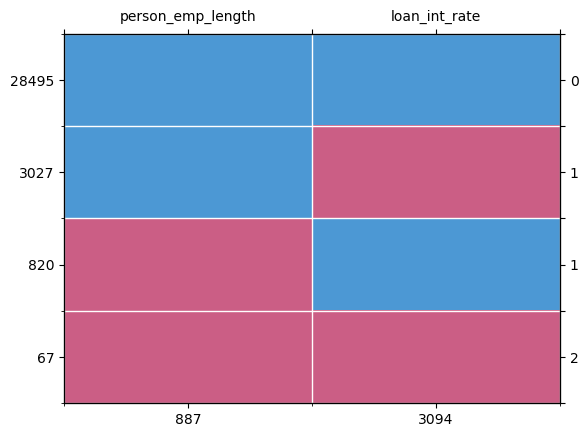

In [10]:
patterns = mdp.get_patterns(nan_dataset)

### MCAR/MAR Testing
* Null Hypothesis: Data is MCAR
* Alternative Hypothesis: Data is not MCAR

#### Little Test (Numeric Observed)

In [11]:
mt_little = MCARTest(method="little")

In [12]:
numeric_dataset = credit_risk_dataset.select_dtypes(
    include=['int64', 'float64']
)

In [13]:
p_value = mt_little.little_mcar_test(
    X=numeric_dataset)
print(F"Little MCAR P value test: {p_value}")
if p_value <= 0.05:
    print(f"Reject H0 MCAR. Y missingness is dependent on X observed values.")
else:
    print(f"Fail to Reject H0 MCAR. Y missingness isn't dependent on X observed values.")

Little MCAR P value test: 0.0
Reject H0 MCAR. Y missingness is dependent on X observed values.


Reject the Null Hypothesis - The test determined the data is not MCAR; Its either MAR or MNAR.

#### T-Test (Numeric Observed)

In [14]:
credit_risk_dataset['pel_missing'] = credit_risk_dataset['person_emp_length'].isnull()

In [15]:
credit_risk_dataset['lir_missing'] = credit_risk_dataset['loan_int_rate'].isnull()

In [16]:
credit_risk_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32409 entries, 0 to 32573
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32409 non-null  int64  
 1   person_income               32409 non-null  int64  
 2   person_home_ownership       32409 non-null  object 
 3   person_emp_length           31522 non-null  float64
 4   loan_intent                 32409 non-null  object 
 5   loan_grade                  32409 non-null  object 
 6   loan_amnt                   32409 non-null  int64  
 7   loan_int_rate               29315 non-null  float64
 8   loan_status                 32409 non-null  bool   
 9   loan_percent_income         32409 non-null  float64
 10  cb_person_default_on_file   32409 non-null  bool   
 11  cb_person_cred_hist_length  32409 non-null  int64  
 12  pel_missing                 32409 non-null  bool   
 13  lir_missing                 324

In [17]:
numeric_features = credit_risk_dataset.select_dtypes(
    include = ['int64', 'float64']
).drop(labels=['person_emp_length', 'loan_int_rate'],
       axis=1
)

In [18]:
dummy_indicators = credit_risk_dataset[["pel_missing", "lir_missing"]]

In [19]:
pel_h0_rejection_count = 0
lir_h0_rejection_count = 0
pel_h0_fail_rejection_count = 0
lir_h0_fail_rejection_count = 0
for numeric_feature in numeric_features:
    for dummy_indicator in dummy_indicators:
        observed_group = credit_risk_dataset.loc[credit_risk_dataset[dummy_indicator] == 0, numeric_feature]
        missing_group = credit_risk_dataset.loc[credit_risk_dataset[dummy_indicator] == 1, numeric_feature]
        t_stat, p_value_ttest = stats.ttest_ind(observed_group,
                         missing_group,
                         equal_var=False)
        print(f"t-test for {numeric_feature} and {dummy_indicator}")
        print(f"P value {p_value_ttest:.4f}")
        if p_value_ttest <= 0.05:
            print("Conclusion: Reject H0 MCAR - Missingness of Y depends on X.")
            if dummy_indicator == "pel_missing":
                pel_h0_rejection_count += 1
            else:
                lir_h0_rejection_count += 1
        else:
            print("Conclusion: Fail to Reject H0 MCAR - Missingness of Y doesn't depend on X.")
            if dummy_indicator == "pel_missing":
                pel_h0_fail_rejection_count += 1
            else:
                lir_h0_fail_rejection_count += 1
print(f"Number of times H0 was rejected because it was PEL:{pel_h0_rejection_count}")
print(f"Number of times H0 was rejected because it was LIR: {lir_h0_rejection_count}")
print(f"Number of times H0 was failed rejected because it was PEL:{pel_h0_fail_rejection_count}")
print(f"Number of times H0 was failed rejected because it was LIR: {lir_h0_fail_rejection_count}")

t-test for person_age and pel_missing
P value 0.0326
Conclusion: Reject H0 MCAR - Missingness of Y depends on X.
t-test for person_age and lir_missing
P value 0.1085
Conclusion: Fail to Reject H0 MCAR - Missingness of Y doesn't depend on X.
t-test for person_income and pel_missing
P value 0.0000
Conclusion: Reject H0 MCAR - Missingness of Y depends on X.
t-test for person_income and lir_missing
P value 0.4611
Conclusion: Fail to Reject H0 MCAR - Missingness of Y doesn't depend on X.
t-test for loan_amnt and pel_missing
P value 0.0000
Conclusion: Reject H0 MCAR - Missingness of Y depends on X.
t-test for loan_amnt and lir_missing
P value 0.6021
Conclusion: Fail to Reject H0 MCAR - Missingness of Y doesn't depend on X.
t-test for loan_percent_income and pel_missing
P value 0.0000
Conclusion: Reject H0 MCAR - Missingness of Y depends on X.
t-test for loan_percent_income and lir_missing
P value 0.5779
Conclusion: Fail to Reject H0 MCAR - Missingness of Y doesn't depend on X.
t-test for cb_

It appears that PEL is MAR, but LIR is MCAR - So, people appear to be refusing to enter their employment length due to other variables in the dataset; whereas, the loan interest rates are randomly missing.

#### Logistic Regression (Numeric Observed)

In [20]:
dir(smf)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'conditional_logit',
 'conditional_mnlogit',
 'conditional_poisson',
 'gee',
 'glm',
 'glmgam',
 'gls',
 'glsar',
 'logit',
 'mixedlm',
 'mnlogit',
 'negativebinomial',
 'nominal_gee',
 'ols',
 'ordinal_gee',
 'phreg',
 'poisson',
 'probit',
 'quantreg',
 'rlm',
 'wls']

In [21]:
credit_risk_dataset['pel_missing'] = credit_risk_dataset['pel_missing'].astype(int)

In [22]:
credit_risk_dataset["lir_missing"] = credit_risk_dataset["lir_missing"].astype(int)

In [23]:
pred_df = credit_risk_dataset.select_dtypes(include=['int64', 'float64', 'int32']).drop(labels=['pel_missing', 'lir_missing'], axis=1)
pred_df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,21,9600,5.0,1000,11.14,0.10,2
1,25,9600,1.0,5500,12.87,0.57,3
2,23,65500,4.0,35000,15.23,0.53,2
3,24,54400,8.0,35000,14.27,0.55,4
4,21,9900,2.0,2500,7.14,0.25,2
...,...,...,...,...,...,...,...
32569,57,53000,1.0,5800,13.16,0.11,30
32570,54,120000,4.0,17625,7.49,0.15,19
32571,65,76000,3.0,35000,10.99,0.46,28
32572,56,150000,5.0,15000,11.48,0.10,26


In [24]:
dummy_indicator = credit_risk_dataset[['pel_missing', 'lir_missing']]

In [25]:
for dummy in dummy_indicator:
    if dummy == 'pel_missing':
        pel_df = credit_risk_dataset.select_dtypes(
            include=['int64', 'float64']
                ).drop(
                labels=['person_emp_length'],
                axis=1)
        pel_model = smf.logit(
            formula = f"{dummy} ~ " + " + ".join(pel_df),
            data = credit_risk_dataset
        ).fit(disp=False)
        print("The Summary for predicting missing in PEL", pel_model.summary())
    else:
        lir_df = credit_risk_dataset.select_dtypes(
            include=['int64', 'float64']
                ).drop(
                labels=['loan_int_rate'],
                axis=1)
        lir_model = smf.logit(
            formula = f"{dummy} ~ " + " + ".join(lir_df),
            data = credit_risk_dataset
        ).fit(disp=False)
        print("For predicting missingness in LIR: ", lir_model.summary())

The Summary for predicting missing in PEL                            Logit Regression Results                           
Dep. Variable:            pel_missing   No. Observations:                29315
Model:                          Logit   Df Residuals:                    29308
Method:                           MLE   Df Model:                            6
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                 0.06767
Time:                        12:48:06   Log-Likelihood:                -3488.0
converged:                       True   LL-Null:                       -3741.2
Covariance Type:            nonrobust   LLR p-value:                3.680e-106
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.6879      0.309     -5.462      0.000      -2.294      -1.082
person_age                    -0.0032    

Similar to the MCAR Little Test PEL is Mar due to majority of predictor variables being statistically signifigant in predicting missingness in Y; simiarily, LIR is MCAR.

#### Chi Squared Test of Independence (Categorical Observed)

In [26]:
for feature in credit_risk_dataset:
    if credit_risk_dataset[feature].dtype == 'O':
        credit_risk_dataset[feature] = credit_risk_dataset[feature].astype('category')

In [27]:
categorical_df = credit_risk_dataset.select_dtypes(
    include = ['category']
)

In [28]:
for dummy in dummy_indicator:
    for cat_feature in categorical_df:
        ct = pd.crosstab(index = credit_risk_dataset[cat_feature], 
            columns = credit_risk_dataset[dummy])
        statistic, pvalue_chi2, dof, expected_freq = stats.chi2_contingency(
            observed = ct
        )
        if pvalue_chi2 < 0.05:
            print(f"Conclusion: Reject H0 (MCAR) pvalue {pvalue_chi2:.3f}: Missingness of {dummy} depends on {cat_feature}.")
        else:
            print(F"Conclusion: Fail to Reject H0 (MCAR) pvalue {pvalue_chi2:.3f}: Missingness in {dummy} is completely at random when compared to {cat_feature}")

Conclusion: Reject H0 (MCAR) pvalue 0.000: Missingness of pel_missing depends on person_home_ownership.
Conclusion: Fail to Reject H0 (MCAR) pvalue 0.895: Missingness in pel_missing is completely at random when compared to loan_intent
Conclusion: Reject H0 (MCAR) pvalue 0.000: Missingness of pel_missing depends on loan_grade.
Conclusion: Fail to Reject H0 (MCAR) pvalue 0.256: Missingness in lir_missing is completely at random when compared to person_home_ownership
Conclusion: Fail to Reject H0 (MCAR) pvalue 0.144: Missingness in lir_missing is completely at random when compared to loan_intent
Conclusion: Fail to Reject H0 (MCAR) pvalue 0.090: Missingness in lir_missing is completely at random when compared to loan_grade


The same conclusion is true for the categorical variables: pel_missing is MAR and lir_missing is MCAR.

#### Logistic Regression (Categorical Observed)

In [29]:
credit_risk_dataset_copy = credit_risk_dataset.copy()

In [30]:
credit_risk_dataset_copy["person_home_ownership"] = credit_risk_dataset_copy["person_home_ownership"].replace(
    to_replace = "OTHER",
    value = "MORTGAGE"  
)

In [31]:
credit_risk_dataset_copy["loan_grade"] = credit_risk_dataset_copy["loan_grade"].replace(
    to_replace = "G",
    value = "F"  
)

In [32]:
for dummy in dummy_indicator:
    if dummy == 'pel_missing':
        pel_model = smf.logit(
            formula = f"{dummy} ~ " + " + ".join(categorical_df),
            data = credit_risk_dataset_copy
        ).fit(disp=False)
        print("The Summary for predicting missing in PEL", pel_model.summary())
    else:
        lir_model = smf.logit(
            formula = f"{dummy} ~ " + " + ".join(categorical_df),
            data = credit_risk_dataset_copy
        ).fit(disp=False)
        print("For predicting missingness in LIR: ", lir_model.summary())

The Summary for predicting missing in PEL                            Logit Regression Results                           
Dep. Variable:            pel_missing   No. Observations:                32409
Model:                          Logit   Df Residuals:                    32396
Method:                           MLE   Df Model:                           12
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                 0.02413
Time:                        12:48:06   Log-Likelihood:                -3968.4
converged:                       True   LL-Null:                       -4066.5
Covariance Type:            nonrobust   LLR p-value:                 1.974e-35
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -3.2195      0.099    -32.653      0.000      -3.413      -3.026
person_home_ownership[T.OWN] 

In [33]:
for dummy in dummy_indicator:
    for cat_feature in categorical_df:
        ct = pd.crosstab(index=credit_risk_dataset_copy[dummy],
                     columns=credit_risk_dataset_copy[cat_feature])
        print(ct)

person_home_ownership  MORTGAGE   OWN   RENT
pel_missing                                 
0                         13124  2391  16007
1                           348   172    367
loan_intent  DEBTCONSOLIDATION  EDUCATION  HOMEIMPROVEMENT  MEDICAL  PERSONAL  \
pel_missing                                                                     
0                         5044       6246             3499     5869      5346   
1                          145        163               95      173       150   

loan_intent  VENTURE  
pel_missing           
0               5518  
1                161  
loan_grade       A      B     C     D    E    F
pel_missing                                    
0            10300  10121  6301  3549  951  300
1              402    263   135    70   12    5
person_home_ownership  MORTGAGE   OWN   RENT
lir_missing                                 
0                         12144  2336  14835
1                          1328   227   1539
loan_intent  DEBTCONSOLIDATION 

PEL_missing is MAR and LIR_missing is MCAR - same results as before.

#### MCAR Visualization

Text(0.5, 1.0, 'Missingness of PEL related to Personal Income')

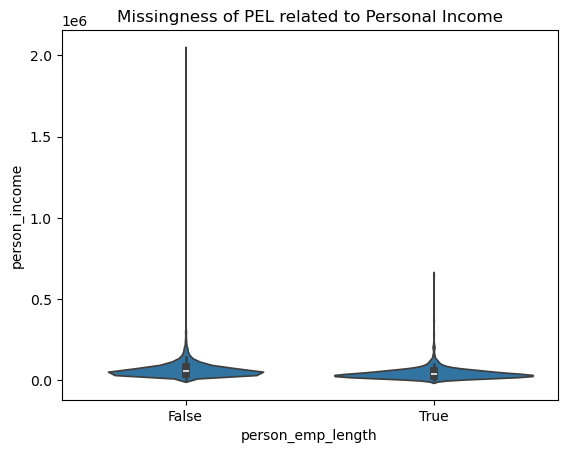

In [34]:
sns.violinplot(
        x=credit_risk_dataset['person_emp_length'].isnull(),
        y="person_income",
        data=credit_risk_dataset
    )
plt.title("Missingness of PEL related to Personal Income")

Text(0.5, 1.0, 'Missingness of PEL related to Loan Amount')

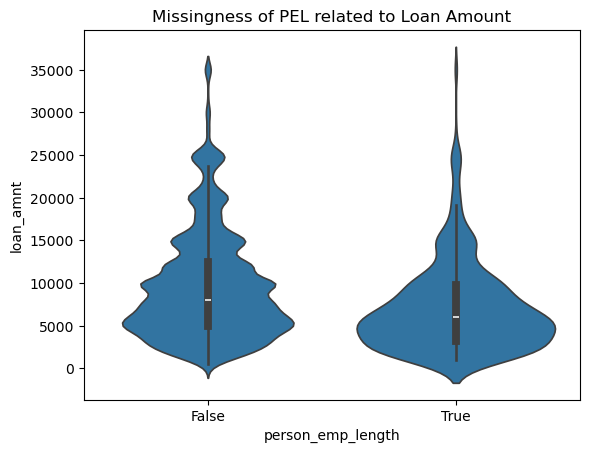

In [35]:
sns.violinplot(
        x=credit_risk_dataset['person_emp_length'].isnull(),
        y="loan_amnt",
        data=credit_risk_dataset
    )
plt.title("Missingness of PEL related to Loan Amount")

Text(0.5, 1.0, 'Missingness of LIR related to Personal Income')

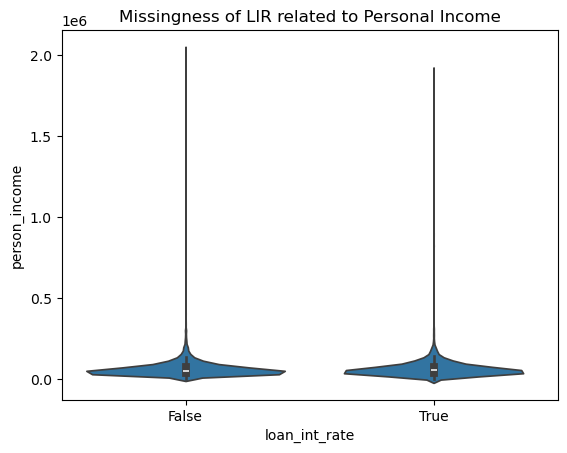

In [36]:
sns.violinplot(
        x=credit_risk_dataset.loan_int_rate.isnull(),
        y="person_income",
        data=credit_risk_dataset
    )
plt.title("Missingness of LIR related to Personal Income")

Text(0.5, 1.0, 'Missingness of LIR related to Personal Income')

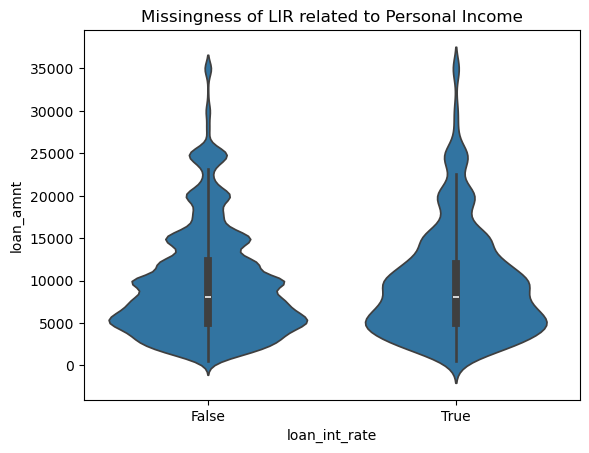

In [37]:
sns.violinplot(
        x=credit_risk_dataset.loan_int_rate.isnull(),
        y="loan_amnt",
        data=credit_risk_dataset
    )
plt.title("Missingness of LIR related to Personal Income")

#### The distributions appear to be similar, which would indicate that MAR is not at play; therefore MNAR is the probable cause for missing data - They either didn't want to put their employment length due to it being short or they didn't want to put their interest rate due to it being too high.

### 

## Train/Test/Split

In [38]:
credit_risk_dataset

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,pel_missing,lir_missing
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,False,0.10,False,2,0,0
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,True,0.57,False,3,0,0
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,True,0.53,False,2,0,0
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,True,0.55,True,4,0,0
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,True,0.25,False,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32569,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,False,0.11,False,30,0,0
32570,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,False,0.15,False,19,0,0
32571,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,True,0.46,False,28,0,0
32572,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,False,0.10,False,26,0,0


In [39]:
X = credit_risk_dataset.drop(
    labels='loan_status',
    axis=1
)

In [40]:
y = credit_risk_dataset.loan_status

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.3,
    random_state = 42
)

## Missing Values

### Identifying Missing Values

In [42]:
credit_risk_dataset.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3094
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
pel_missing                      0
lir_missing                      0
dtype: int64

In [43]:
credit_risk_dataset.isna().sum()/len(credit_risk_dataset)

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027369
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 0.095467
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
pel_missing                   0.000000
lir_missing                   0.000000
dtype: float64

In [44]:
credit_risk_dataset.isna().all(axis=1).sum()

0

In [45]:
credit_risk_dataset.isna().all(axis=0).sum()

0

In [46]:
nan_df = pd.DataFrame(credit_risk_dataset.isna().sum()).T

<Axes: >

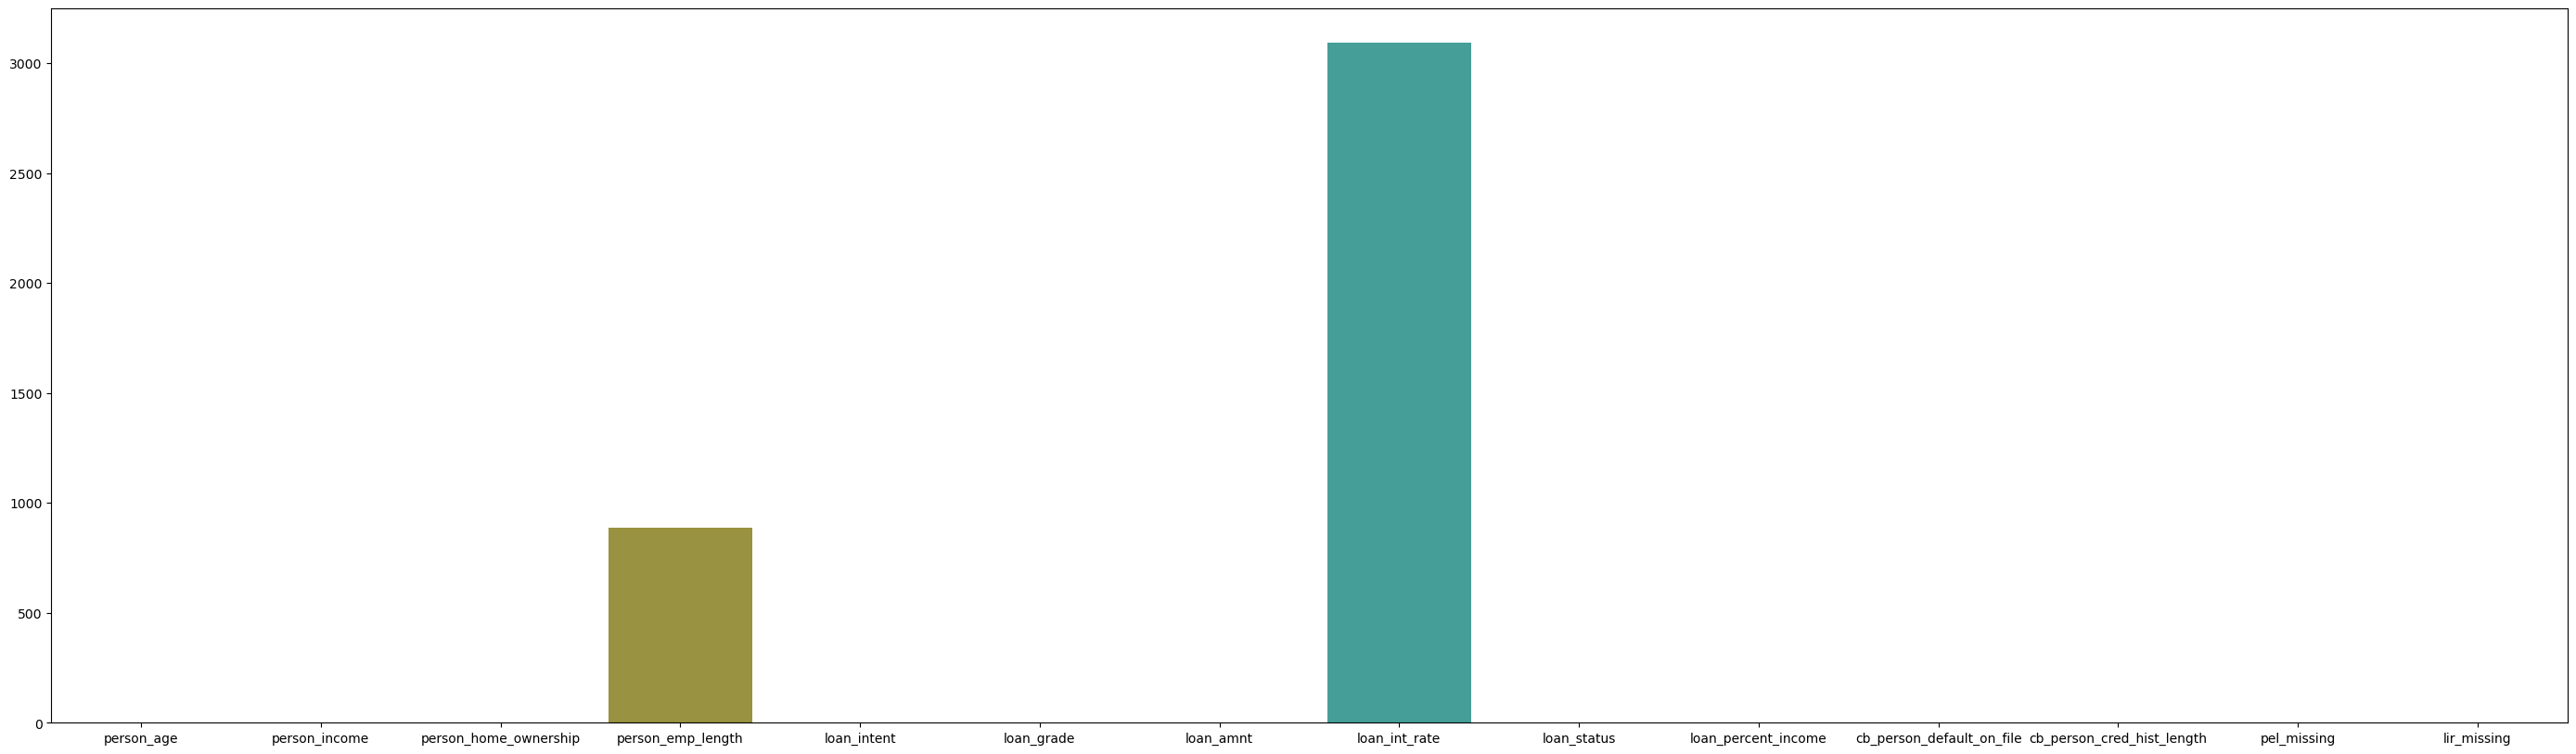

In [47]:
plt.figure(figsize=(35,10))
sns.barplot(
    data= nan_df
)

<Axes: >

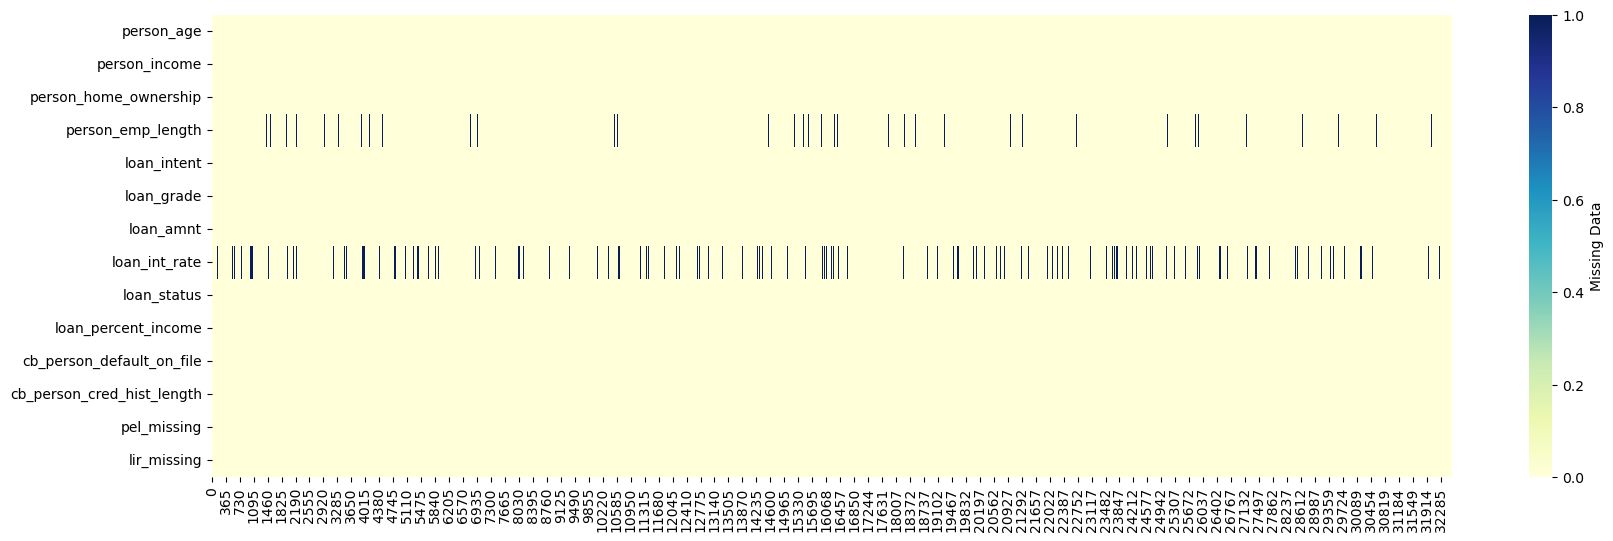

In [48]:
plt.figure(figsize=(20,6))
sns.heatmap(
    credit_risk_dataset.isna().T,
    cmap='YlGnBu',
    cbar_kws={'label': 'Missing Data'}
)

In [49]:
credit_risk_dataset.isna().melt(value_name='missing')

,variable,missing
0,person_age,False
1,person_age,False
2,person_age,False
3,person_age,False
4,person_age,False
...,...,...
453721,lir_missing,False
453722,lir_missing,False
453723,lir_missing,False
453724,lir_missing,False


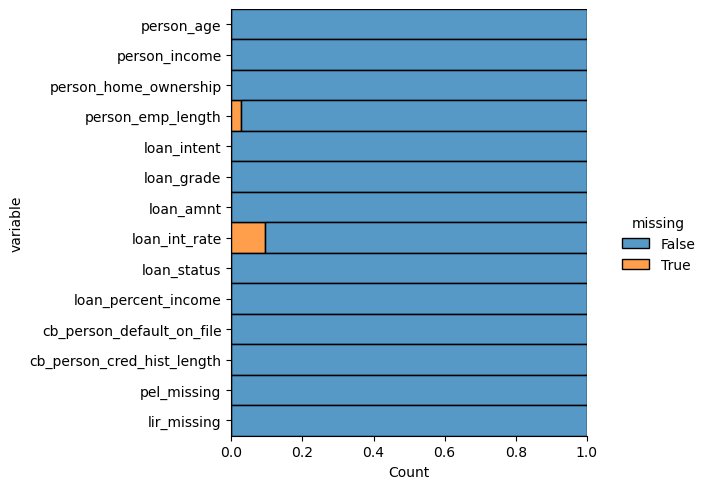

In [50]:
sns.displot(credit_risk_dataset.isna().melt(value_name='missing'),
y='variable',
hue='missing',
multiple='fill',
aspect=1.25
);

### Handling Missing Values

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22686 entries, 20109 to 23776
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  22686 non-null  int64   
 1   person_income               22686 non-null  int64   
 2   person_home_ownership       22686 non-null  category
 3   person_emp_length           22055 non-null  float64 
 4   loan_intent                 22686 non-null  category
 5   loan_grade                  22686 non-null  category
 6   loan_amnt                   22686 non-null  int64   
 7   loan_int_rate               20470 non-null  float64 
 8   loan_percent_income         22686 non-null  float64 
 9   cb_person_default_on_file   22686 non-null  bool    
 10  cb_person_cred_hist_length  22686 non-null  int64   
 11  pel_missing                 22686 non-null  int32   
 12  lir_missing                 22686 non-null  int32   
dtypes: bool(1), 

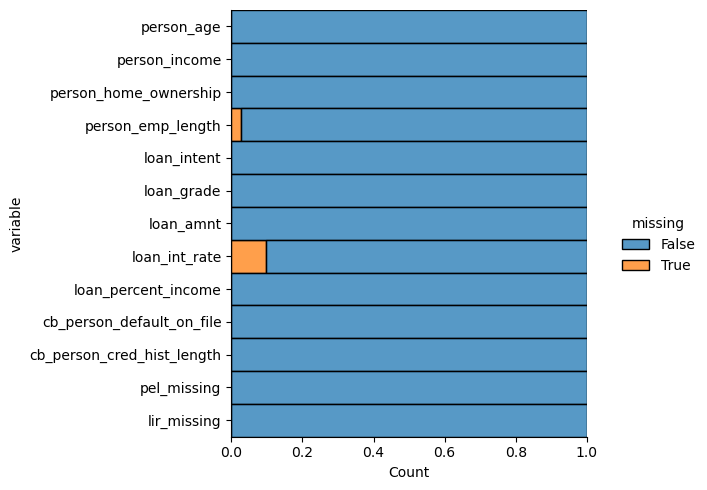

In [52]:
sns.displot(X_train.isna().melt(value_name='missing'),
y='variable',
hue='missing',
multiple='fill',
aspect=1.25
);

The problem with the ColumnTransformer is that it outputs every variable as a object data type in order to concatenate them. Not necessary for manual imputation.

In [53]:
# ct = ColumnTransformer(
#     transformers = [
#         ("imputer", IterativeImputer(max_iter=10, random_state=42), make_column_selector(dtype_include=np.number))
#     ],
#     remainder='passthrough',
#     verbose_feature_names_out = False
# )
# X_train_transformed = ct.fit_transform(X_train)

In [54]:
it = IterativeImputer(max_iter=10, random_state=42)


In [55]:
X_train[numeric_dataset.columns] = it.fit_transform(X_train[numeric_dataset.columns])

In [56]:
X_test[numeric_dataset.columns] = it.transform(X_test[numeric_dataset.columns])

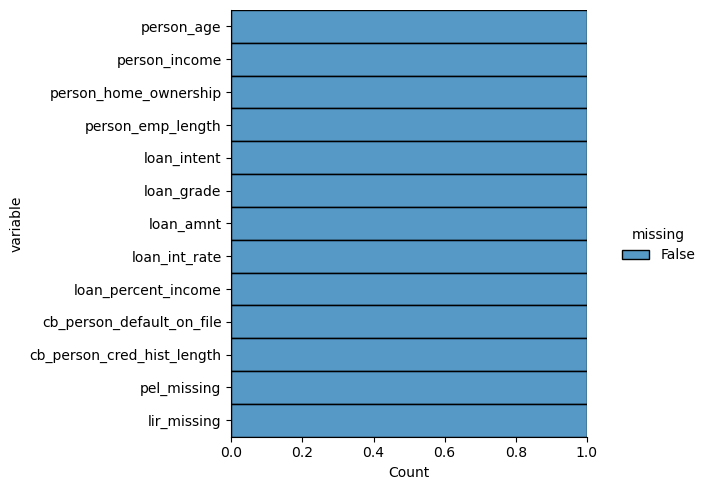

In [57]:
sns.displot(X_train.isna().melt(value_name='missing'),
y='variable',
hue='missing',
multiple='fill',
aspect=1.25
);

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22686 entries, 20109 to 23776
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  22686 non-null  float64 
 1   person_income               22686 non-null  float64 
 2   person_home_ownership       22686 non-null  category
 3   person_emp_length           22686 non-null  float64 
 4   loan_intent                 22686 non-null  category
 5   loan_grade                  22686 non-null  category
 6   loan_amnt                   22686 non-null  float64 
 7   loan_int_rate               22686 non-null  float64 
 8   loan_percent_income         22686 non-null  float64 
 9   cb_person_default_on_file   22686 non-null  bool    
 10  cb_person_cred_hist_length  22686 non-null  float64 
 11  pel_missing                 22686 non-null  int32   
 12  lir_missing                 22686 non-null  int32   
dtypes: bool(1), 

## Outliers

#### Outlier Visualization

In [59]:
credit_risk_dataset

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,pel_missing,lir_missing
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,False,0.10,False,2,0,0
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,True,0.57,False,3,0,0
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,True,0.53,False,2,0,0
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,True,0.55,True,4,0,0
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,True,0.25,False,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32569,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,False,0.11,False,30,0,0
32570,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,False,0.15,False,19,0,0
32571,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,True,0.46,False,28,0,0
32572,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,False,0.10,False,26,0,0


### IQR Method

In [60]:
Q1 = X_train['person_income'].quantile(0.25)

In [61]:
Q3 = X_train['person_income'].quantile(0.75)

In [62]:
IQR = Q3 - Q1

In [63]:
lower_bound = Q1 - (IQR * 1.5)

In [64]:
upper_bound = Q3 + (1.5 * IQR)

In [65]:
X_train[(X_train["person_income"] < lower_bound) | (X_train["person_income"] > upper_bound)].shape[0]

1115

In [66]:
outlier_dict = dict()
for numeric_feature in numeric_dataset:
    Q1 = X_train[numeric_feature].quantile(0.25)
    Q3 = X_train[numeric_feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (IQR * 1.5)
    upper_bound = Q3 + (1.5 * IQR)
    outlier_count = X_train[(X_train[numeric_feature] < lower_bound) | (X_train[numeric_feature] > upper_bound)].shape[0]
    print(f"The amount of outliers in credit risk dataset for the {numeric_feature} is:", outlier_count)
    outlier_dict[numeric_feature + "_outlier_count"] = outlier_count

The amount of outliers in credit risk dataset for the person_age is: 1039
The amount of outliers in credit risk dataset for the person_income is: 1115
The amount of outliers in credit risk dataset for the person_emp_length is: 588
The amount of outliers in credit risk dataset for the loan_amnt is: 1229
The amount of outliers in credit risk dataset for the loan_int_rate is: 52
The amount of outliers in credit risk dataset for the loan_percent_income is: 471
The amount of outliers in credit risk dataset for the cb_person_cred_hist_length is: 780


In [67]:
outlier_count = pd.Series(outlier_dict).sort_values()

### Z Score Method

In [68]:
for numeric_feature in numeric_dataset:
    z_score = stats.zscore(X_train[numeric_feature])
    outliers = X_train[numeric_feature][z_score > 3]
    print(f"The number of outliers in {numeric_feature} based on z_score is:", len(outliers))

The number of outliers in person_age based on z_score is: 365
The number of outliers in person_income based on z_score is: 240
The number of outliers in person_emp_length based on z_score is: 302
The number of outliers in loan_amnt based on z_score is: 231
The number of outliers in loan_int_rate based on z_score is: 40
The number of outliers in loan_percent_income based on z_score is: 244
The number of outliers in cb_person_cred_hist_length based on z_score is: 187


### Handling Outliers Values

In [69]:
# ct_outlier = ColumnTransformer(
#     transformers = [
#         ("outlier", Winsorizer(capping_method='iqr', tail='both', fold=1.5), make_column_selector(dtype_include=np.number)),
#     ],
#     remainder='passthrough'
# )
# X_train_transformed = ct_outlier.fit_transform(X_train_transformed)

In [70]:
numeric_cols = list(numeric_dataset.columns)

In [71]:
w = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables = numeric_cols)

In [72]:
X_train[numeric_dataset.columns] = w.fit_transform(X_train[numeric_dataset.columns])

In [73]:
X_test[numeric_dataset.columns] = w.transform(X_test[numeric_dataset.columns])

In [74]:
outlier_dict = dict()
for numeric_feature in numeric_dataset:
    Q1 = X_train[numeric_feature].quantile(0.25)
    Q3 = X_train[numeric_feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (IQR * 1.5)
    upper_bound = Q3 + (1.5 * IQR)
    outlier_count = X_train[(X_train[numeric_feature] < lower_bound) | (X_train[numeric_feature] > upper_bound)].shape[0]
    print(f"The amount of outliers in credit risk dataset for the {numeric_feature} is:", outlier_count)
    outlier_dict[numeric_feature + "_outlier_count"] = outlier_count

The amount of outliers in credit risk dataset for the person_age is: 0
The amount of outliers in credit risk dataset for the person_income is: 0
The amount of outliers in credit risk dataset for the person_emp_length is: 0
The amount of outliers in credit risk dataset for the loan_amnt is: 0
The amount of outliers in credit risk dataset for the loan_int_rate is: 0
The amount of outliers in credit risk dataset for the loan_percent_income is: 0
The amount of outliers in credit risk dataset for the cb_person_cred_hist_length is: 0


In [75]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22686 entries, 20109 to 23776
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  22686 non-null  float64 
 1   person_income               22686 non-null  float64 
 2   person_home_ownership       22686 non-null  category
 3   person_emp_length           22686 non-null  float64 
 4   loan_intent                 22686 non-null  category
 5   loan_grade                  22686 non-null  category
 6   loan_amnt                   22686 non-null  float64 
 7   loan_int_rate               22686 non-null  float64 
 8   loan_percent_income         22686 non-null  float64 
 9   cb_person_default_on_file   22686 non-null  bool    
 10  cb_person_cred_hist_length  22686 non-null  float64 
 11  pel_missing                 22686 non-null  int32   
 12  lir_missing                 22686 non-null  int32   
dtypes: bool(1), 

## Power Tranformation

##### Non-Normal Visualization

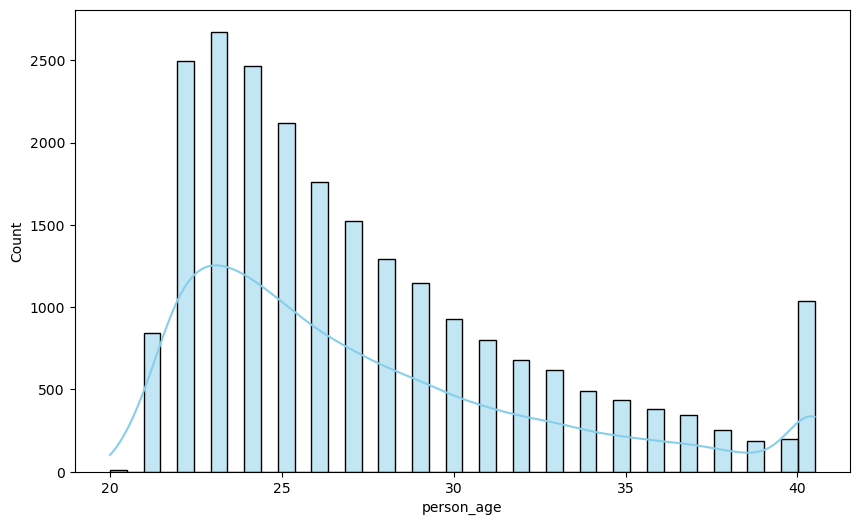

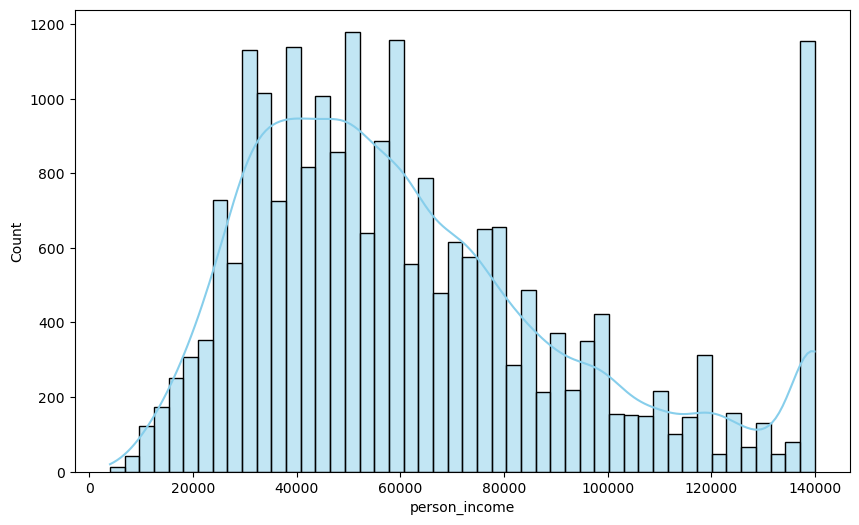

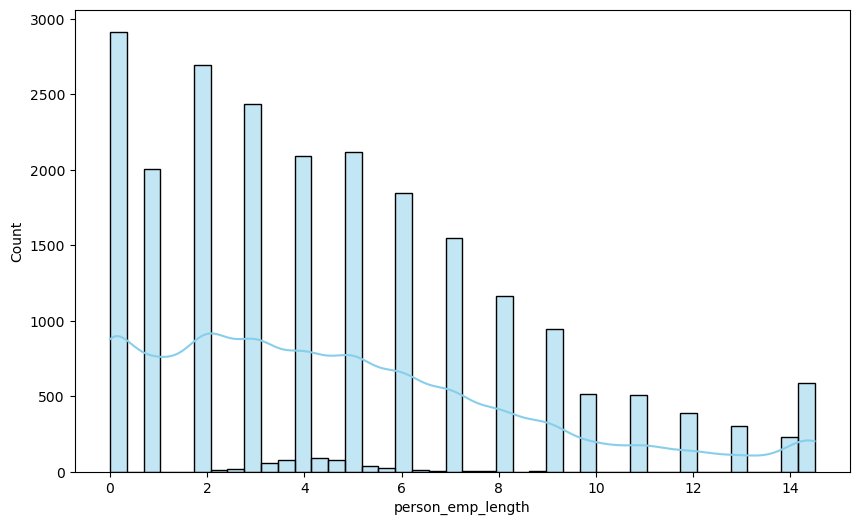

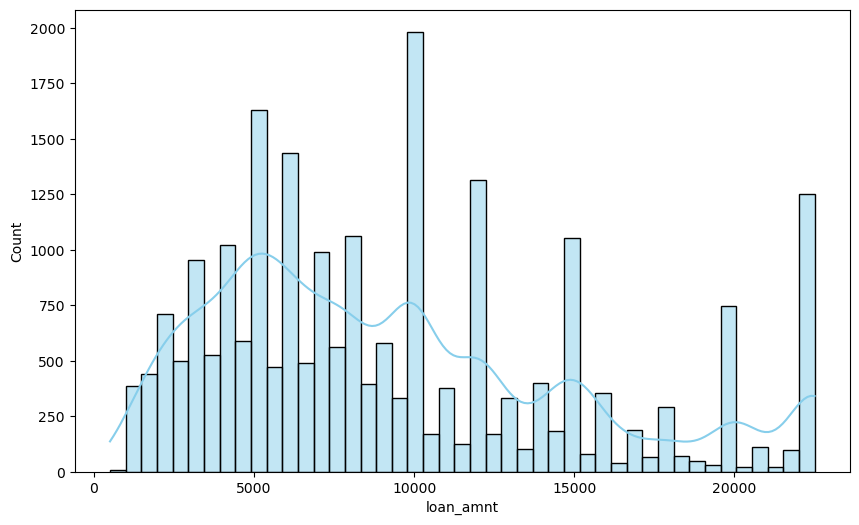

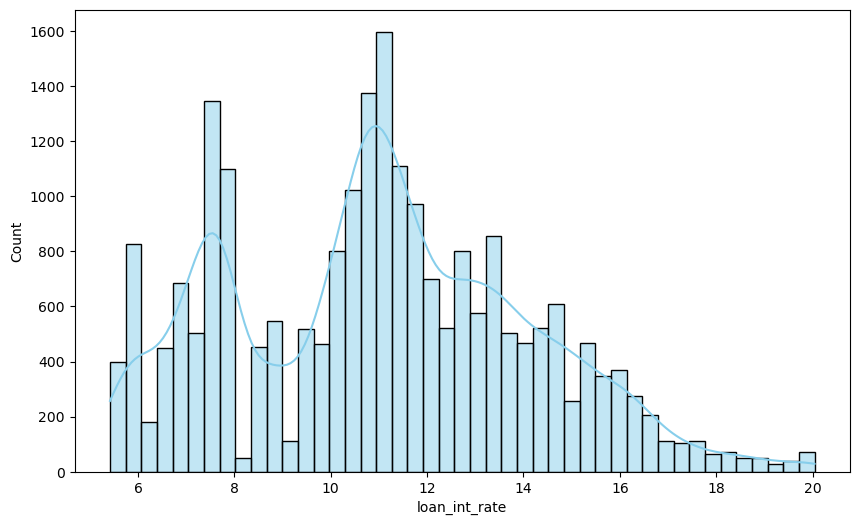

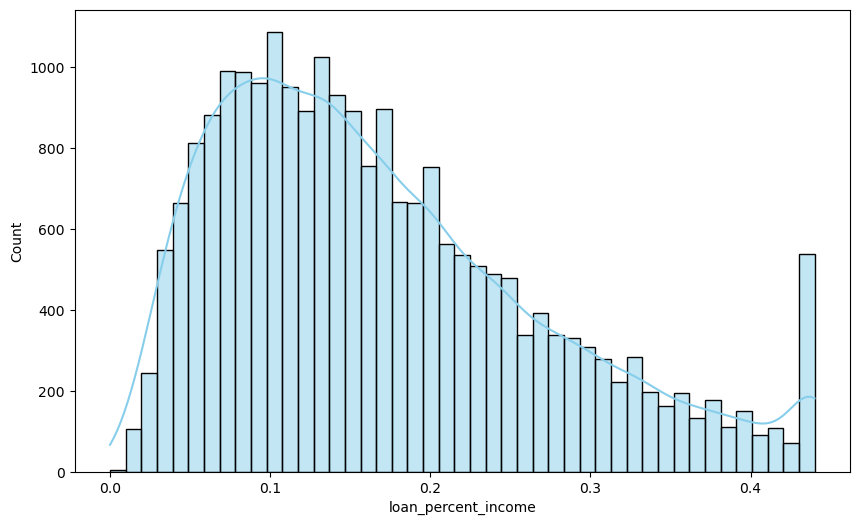

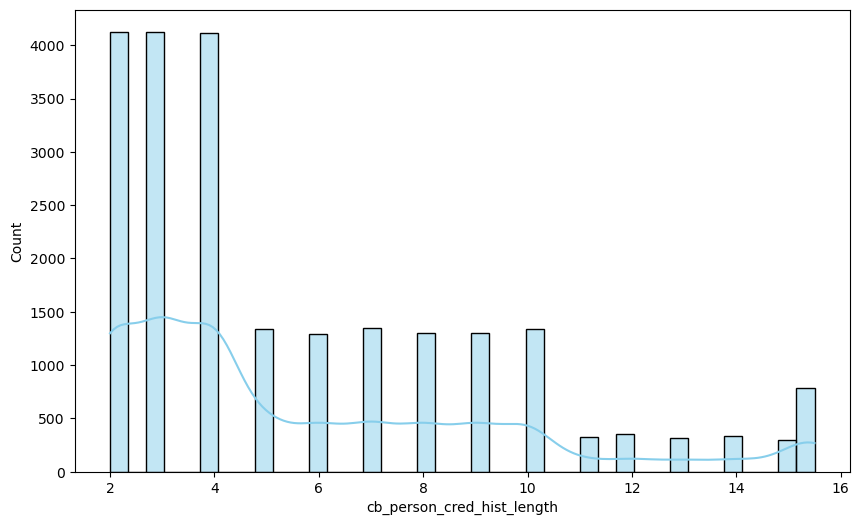

In [76]:
for numeric_feature in numeric_dataset:
    plt.figure(figsize=(10,6))

    sns.histplot(
        data=X_train[numeric_feature],
        kde = True,
    color = 'skyblue'
    )

In [77]:
X_train['loan_amnt']

20109    10750.0
20513     4800.0
1274     16000.0
31364    22000.0
27571    18000.0
          ...   
29961     5000.0
5390      5000.0
860       3000.0
15795    16000.0
23776     9600.0
Name: loan_amnt, Length: 22686, dtype: float64

c:\Users\billy\anaconda3\envs\credit_risk_modeling\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 1000x600 with 0 Axes>

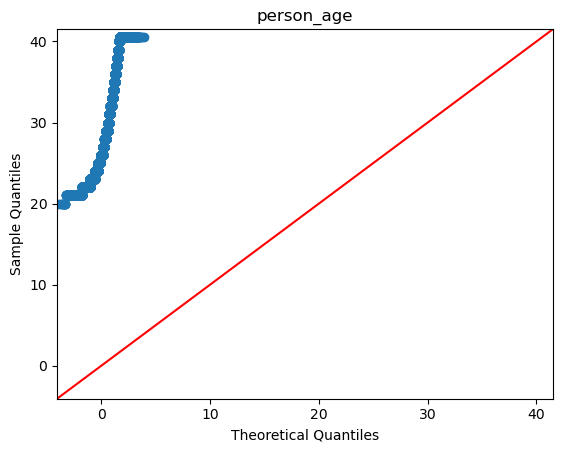

<Figure size 1000x600 with 0 Axes>

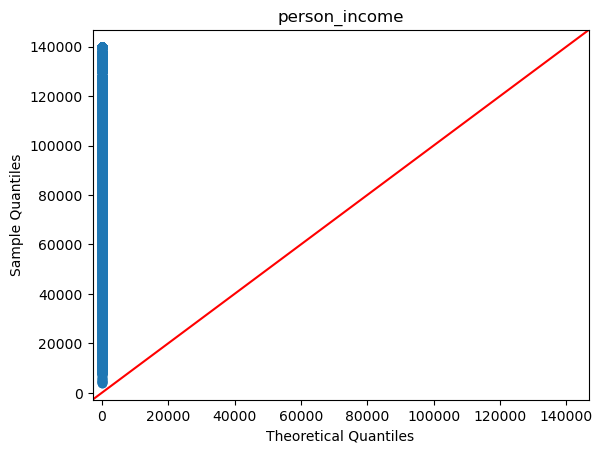

<Figure size 1000x600 with 0 Axes>

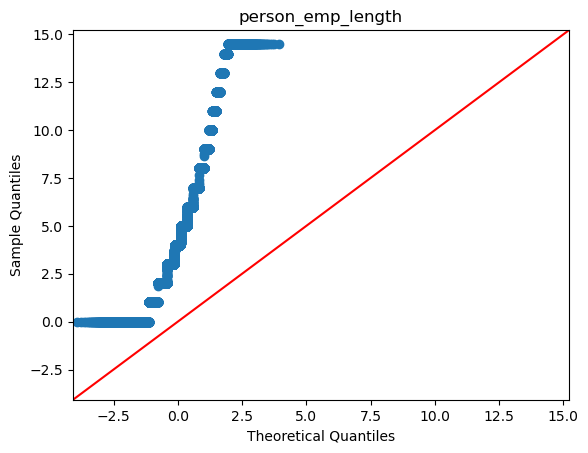

<Figure size 1000x600 with 0 Axes>

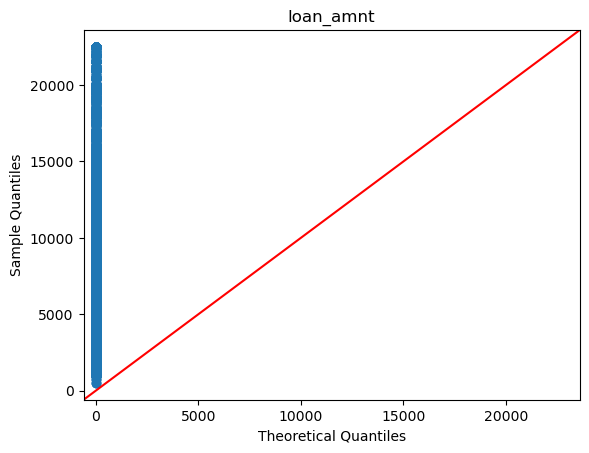

<Figure size 1000x600 with 0 Axes>

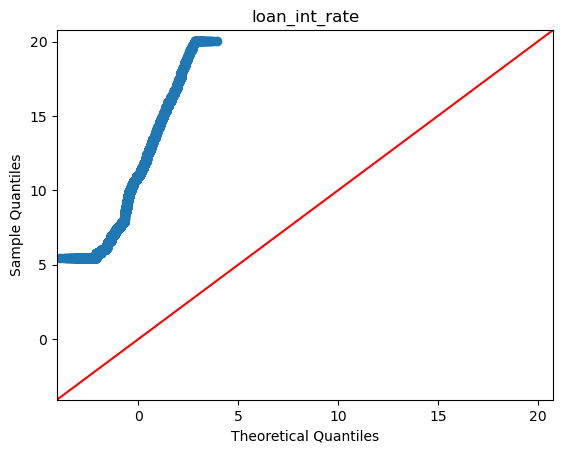

<Figure size 1000x600 with 0 Axes>

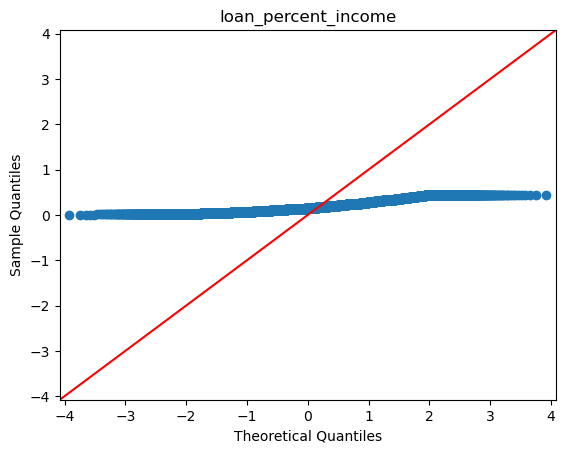

<Figure size 1000x600 with 0 Axes>

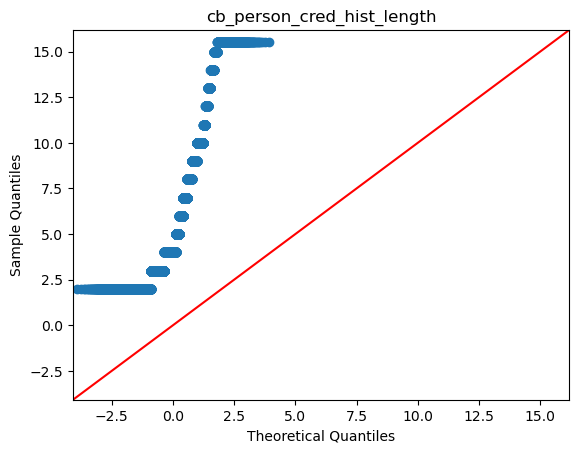

In [78]:
for numeric_feature in numeric_dataset:
    plt.figure(figsize=(10,6))

    sm.qqplot(
        data=X_train[numeric_feature].sort_values(ascending=True),
        color = 'skyblue',
        line='45'
    )
    plt.title(numeric_feature)

In [79]:
for numeric_feature in numeric_dataset:
    statistic, pvalue = shapiro(X_train[numeric_feature])
    is_normal = f"Reject H0. The data in {numeric_feature} is not normally distributed." if pvalue < 0.05 else "Fail to reject H0 (Appears Normal)"
    print(f"Test Statistic: {statistic:.4f} | p-value: {pvalue:.4f} | conclusion: {is_normal}")

Test Statistic: 0.8855 | p-value: 0.0000 | conclusion: Reject H0. The data in person_age is not normally distributed.
Test Statistic: 0.9272 | p-value: 0.0000 | conclusion: Reject H0. The data in person_income is not normally distributed.
Test Statistic: 0.9241 | p-value: 0.0000 | conclusion: Reject H0. The data in person_emp_length is not normally distributed.
Test Statistic: 0.9243 | p-value: 0.0000 | conclusion: Reject H0. The data in loan_amnt is not normally distributed.
Test Statistic: 0.9818 | p-value: 0.0000 | conclusion: Reject H0. The data in loan_int_rate is not normally distributed.
Test Statistic: 0.9361 | p-value: 0.0000 | conclusion: Reject H0. The data in loan_percent_income is not normally distributed.
Test Statistic: 0.8535 | p-value: 0.0000 | conclusion: Reject H0. The data in cb_person_cred_hist_length is not normally distributed.


c:\Users\billy\anaconda3\envs\credit_risk_modeling\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22686.
  res = hypotest_fun_out(*samples, **kwds)


In [80]:
X_train_before_transformation = X_train.copy()

In [81]:
X_train_log_transformation = X_train.copy()

In [82]:
X_train_power_transformation = X_train.copy()

In [83]:
pt = PowerTransformer(method='yeo-johnson', standardize = False)

In [84]:
X_train_power_transformation[numeric_dataset.columns] = pt.fit_transform(X_train_power_transformation[numeric_dataset.columns])

In [85]:
for numeric_feature in numeric_dataset:
    X_train_log_transformation[numeric_feature] = np.log1p(X_train_log_transformation[numeric_feature])

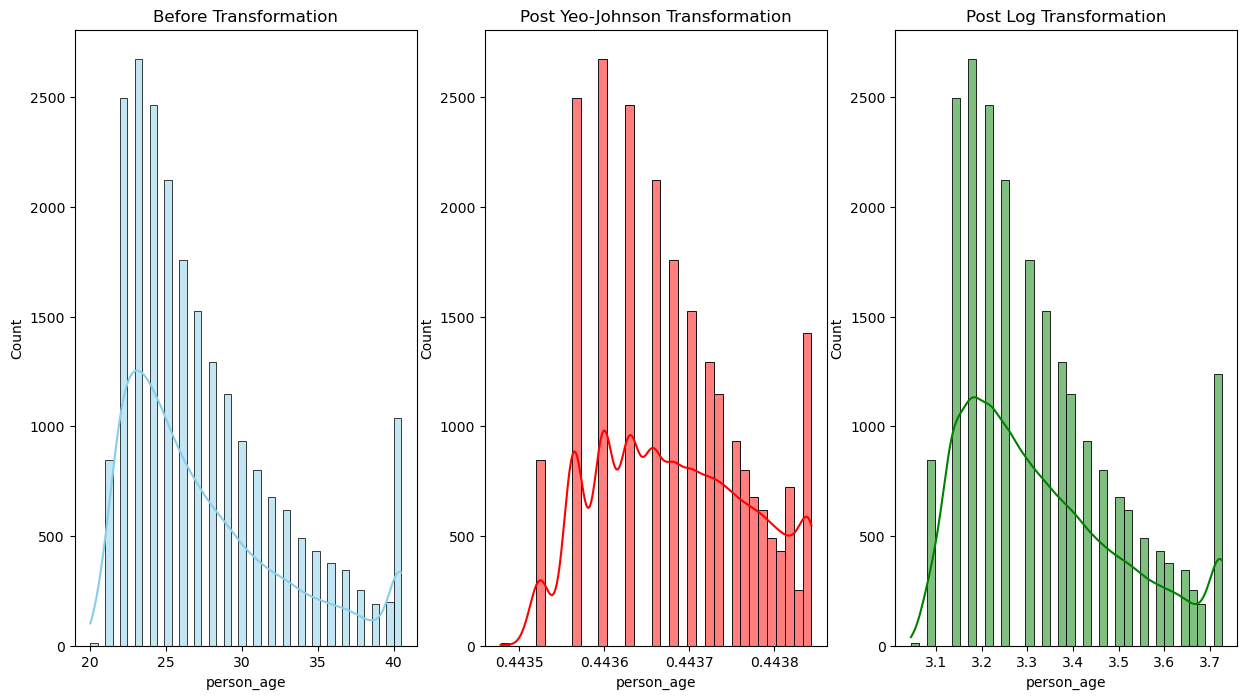

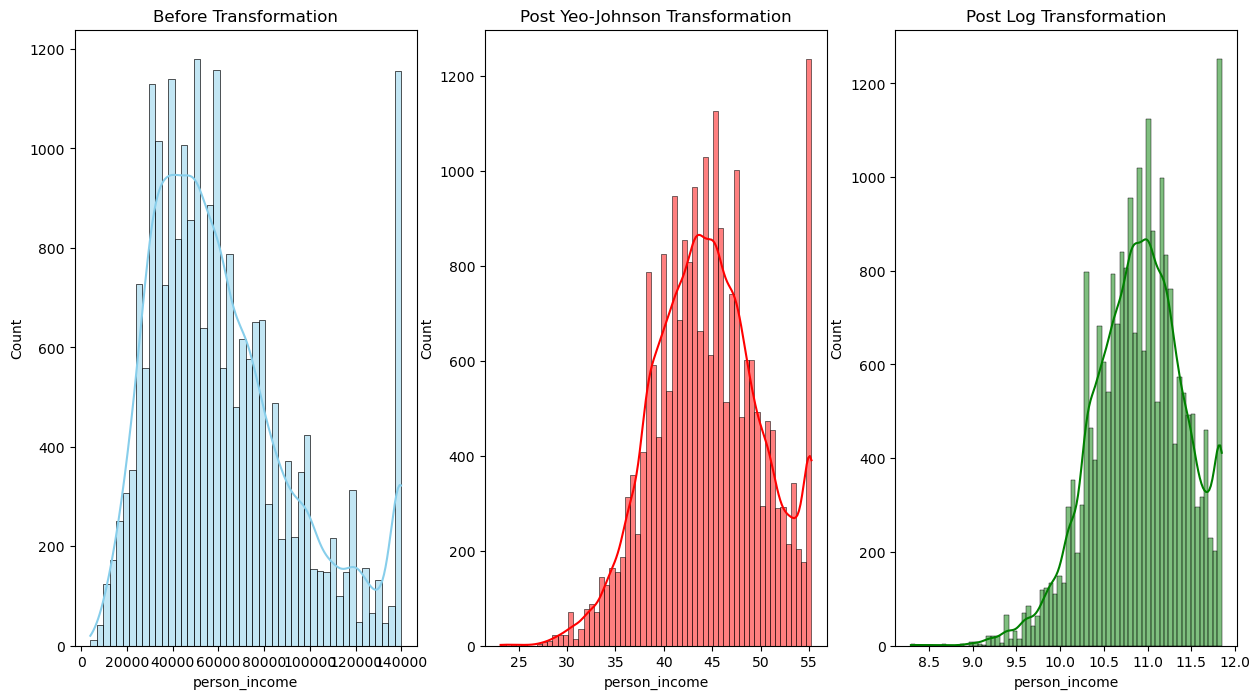

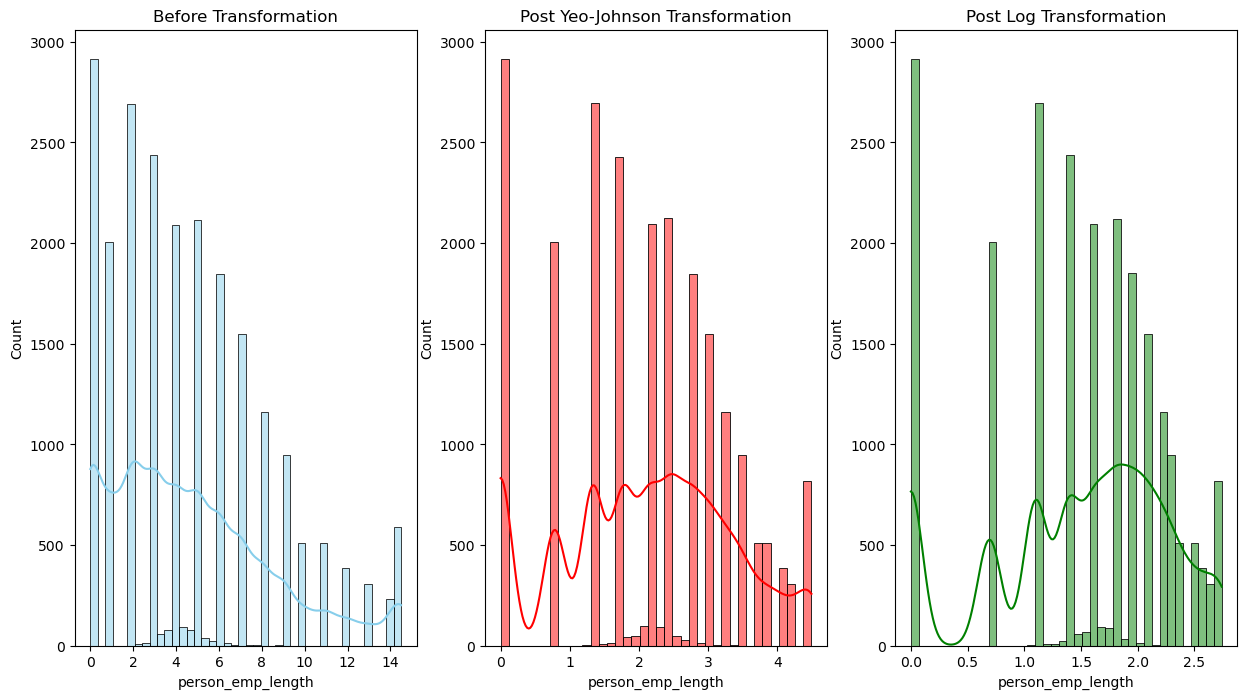

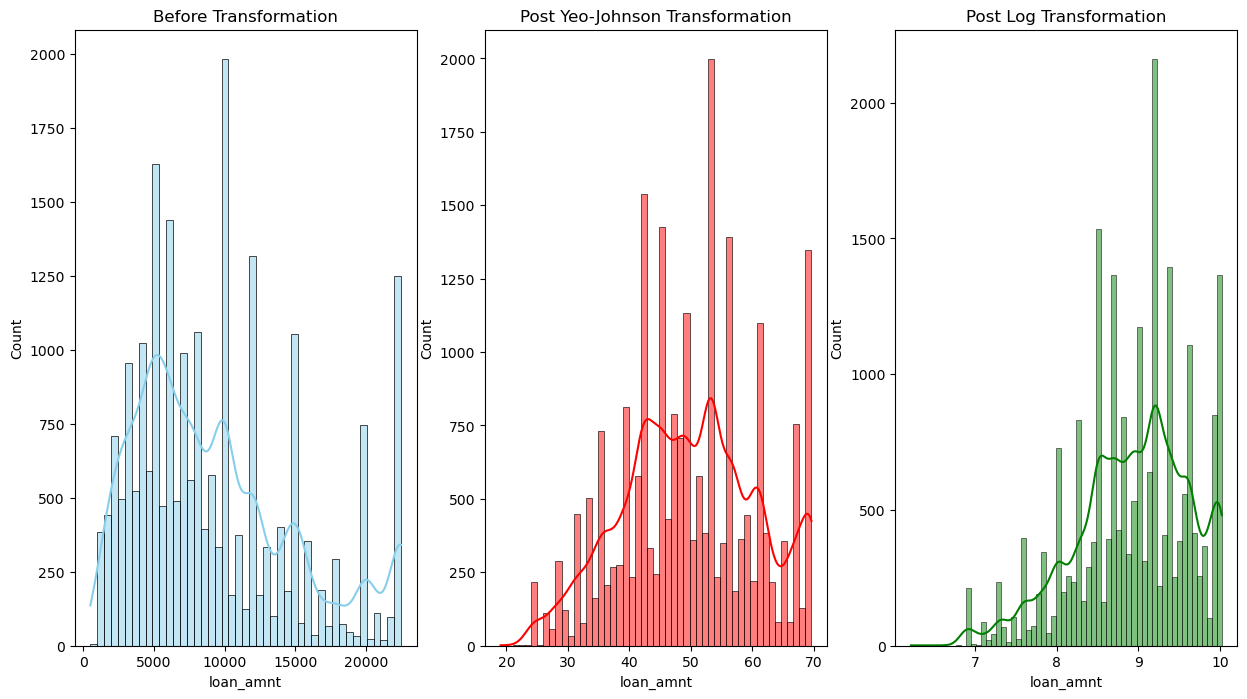

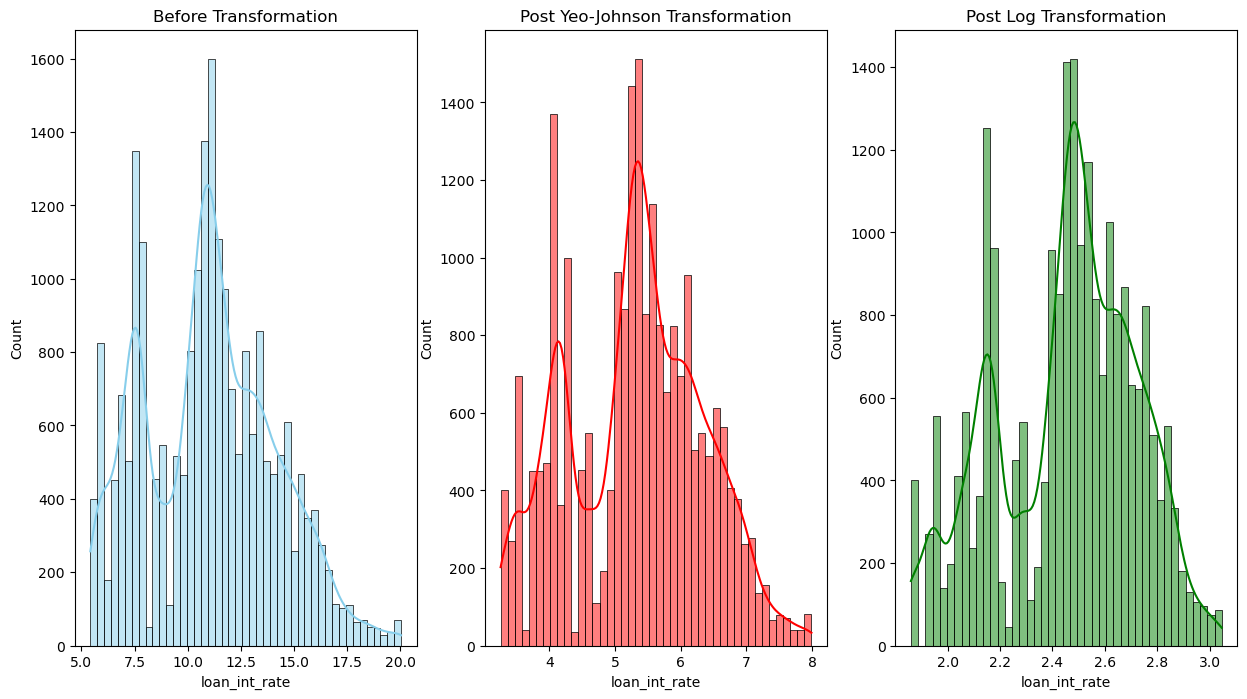

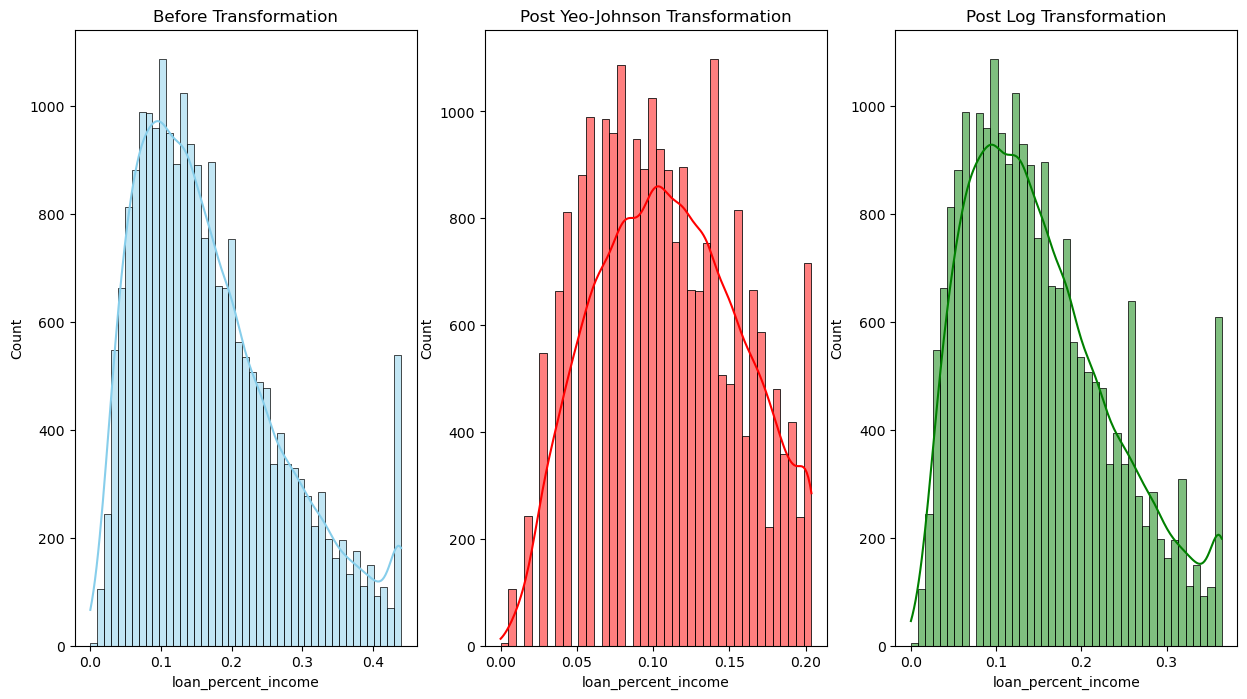

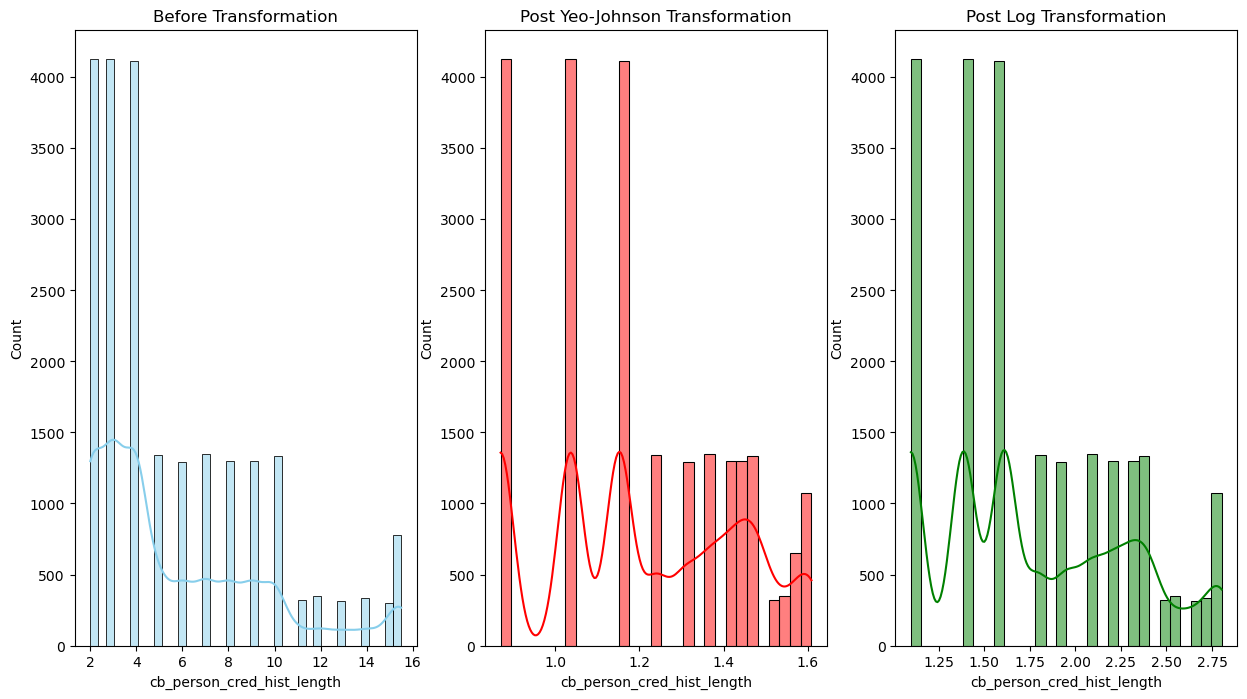

In [86]:
for numeric_feature in numeric_dataset:
    fig, ax = plt.subplots(1, 3, figsize=(15,8))

    sns.histplot(
        data=X_train_before_transformation[numeric_feature],
        kde = True,
    color = 'skyblue',
    ax=ax[0]
    )
    ax[0].set_title("Before Transformation")

    sns.histplot(
        data=X_train_power_transformation[numeric_feature],
        kde = True,
    color = 'red',
    ax=ax[1]
    )
    ax[1].set_title("Post Yeo-Johnson Transformation")

    sns.histplot(
            data=X_train_log_transformation[numeric_feature],
            kde = True,
        color = 'green',
        ax=ax[2]
        )
    ax[2].set_title("Post Log Transformation")